<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/15_PatchTST_a_new_transformer_for_LTSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: oguiza@timeseriesAI.co

# Purpose 😇

In this notebook, we are going to learn how to use a new state-of-the-art time series transformer called **PatchTST** to create a long-term multivariate time series forecast (LTSF). PatchTST was introduced in the following paper:

* paper: Nie, Y., Nguyen, N. H., Sinthong, P., & Kalagnanam, J. (2022). **A Time Series is Worth 64 Words: Long-term Forecasting with Transformers**. arXiv preprint arXiv:2211.14730.
* arxiv link: https://arxiv.org/abs/2211.14730
* official repository: https://github.com/yuqinie98/PatchTST

The paper will be presented at the **ICLR 2023** Conference later this year. Here's the summary of the paper review by ICLR reviewers:

"The paper applies transformer to long term forecasting problems of multi-dimensional time series. The method is very simple: Take channels independently, break them into patches and predict the patches into the future using the transformer. The main advantage of this paper is that previous papers have applied transformers to this problem but it resulted in a very weak performance, being beaten by a simple linear methods. This paper found a way to apply the transformer successfully, beating the previous methods."

I'd like to thank the authors for publishing this paper, and for making their code available.

Below you can see the results of publised in the paper.

![download.png](attachment:download.png)

# Install & import libraries 📚

You'll need tsai >= 0.3.5 to be able to run this tutorial.

In [44]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [45]:
import sklearn
from tsai.basics import *
my_setup(sklearn)

os              : Linux-6.1.58+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
sklearn         : 1.2.2
torch           : 2.1.0+cu121
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : [15.0] GB


# Load and prepare data 🔢

The starting point for this tutorial will be a dataframe that contains our long-term time series data.

`tsai` allows you to easily download and prepare data from 9 popular datasets, including weather, traffic, electricity, exchange rate, ILI, and four ETT datasets (ETTh1, ETTh2, ETTm1, ETTm2). These datasets have been extensively utilized for long-term time series forecasting benchmarking.

You can download all data from here: https://cloud.tsinghua.edu.cn/d/e1ccfff39ad541908bae/

Here are the statistics of these datasets:

| Datasets | Weather | Traffic | Electricity | Exchange | ILI | ETTh1 | ETTh2 | ETTm1 | ETTm2 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Features | 21 | 862 | 321 | 8 | 7 | 7 | 7 | 7 | 7 |
| Timesteps | 52696 | 17544 | 26304 | 7588 | 966 | 17420 | 17420 | 69680 | 69680 |


## Data preparation steps

There are 5 steps required to prepare data for a forecasting task in `tsai`:

1. Prepare a dataframe with your data, including the variable you want to predict.
2. Preprocess your data.
3. Define train, valid and test splits.
4. Scale your data using the train split.
5. Apply a sliding window to prepare your input and output data.

### Prepare dataframe

In this case, we are going to download the dataframe using get_long_term_forecasting_data. You can use any of the following datasets: "ETTh1", "ETTh2", "ETTm1", "ETTm2", "electricity", "exchange_rate", "traffic", "weather", or "ILI".

We are going to use a small dataset called ILI. ILI includes the weekly recorded **influenza-like illness (ILI)** patients data from Centers for
Disease Control and Prevention of the United States between 2002 and 2021, which describes the ratio of patients seen with ILI and the total number of the patients.

The task is a multivariate long-term time series forecasting (LTSF), where multiple variables are predicted simultaneously for multiple time steps.

In [46]:
dsid = "electricity"
# df_raw = get_long_term_forecasting_data(dsid)
df_raw = pd.read_csv('/content/converted_data.csv')
df_raw

,timestamp,room_temp_Mf-1-1,room_temp_Mf-1-2,room_temp_Mf-1-3,room_temp_Mf-2-1-1,room_temp_Mf-2-1-2,room_temp_Mf-2-1-3,room_temp_Mf-2-1-4,room_temp_Ac-2-1,fan_stat_Ac-2-1,...,slab_temp_Mf-2-1-1,slab_temp_Mf-2-1-2,slab_temp_Mf-2-1-3,slab_temp_Mf-2-1-4,slab_temp_Ac-2-1,slab_temp_Mf-2-1,slab_temp_Ac-2-2,slab_temp_Ac-2-3,slab_temp_Ac-2-4,slab_temp_Ac-2-5
0,1679952899,19.4,19.8,20.1,20.9,21.3,20.6,19.5,20.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1679953387,19.4,19.7,20.0,20.9,21.4,20.6,19.5,19.9,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1679953747,19.4,19.7,20.0,20.9,21.4,20.6,19.4,19.9,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1679954947,19.3,19.7,20.0,20.8,21.3,20.6,19.4,19.9,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1679956147,19.3,19.7,20.0,20.8,21.3,20.5,19.3,19.8,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25418,1680773947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25419,1680775147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25420,1680776348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25421,1680777547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Đảm bảo 'date' đã được chuyển đổi thành kiểu dữ liệu datetime
df_raw['date'] = pd.to_datetime(df_raw['timestamp'], unit='s')

# Xóa cột 'timestamp'
df_raw = df_raw.drop(columns=['timestamp'])

# Tạo một danh sách các tên cột mới
columns = ['date'] + [col for col in df_raw.columns if col != 'date']

# Sắp xếp lại các cột theo danh sách
df_raw = df_raw[columns]

# Hiển thị DataFrame
df_raw


,date,room_temp_Mf-1-1,room_temp_Mf-1-2,room_temp_Mf-1-3,room_temp_Mf-2-1-1,room_temp_Mf-2-1-2,room_temp_Mf-2-1-3,room_temp_Mf-2-1-4,room_temp_Ac-2-1,fan_stat_Ac-2-1,...,slab_temp_Mf-2-1-1,slab_temp_Mf-2-1-2,slab_temp_Mf-2-1-3,slab_temp_Mf-2-1-4,slab_temp_Ac-2-1,slab_temp_Mf-2-1,slab_temp_Ac-2-2,slab_temp_Ac-2-3,slab_temp_Ac-2-4,slab_temp_Ac-2-5
0,2023-03-27 21:34:59,19.4,19.8,20.1,20.9,21.3,20.6,19.5,20.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-03-27 21:43:07,19.4,19.7,20.0,20.9,21.4,20.6,19.5,19.9,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-03-27 21:49:07,19.4,19.7,20.0,20.9,21.4,20.6,19.4,19.9,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-03-27 22:09:07,19.3,19.7,20.0,20.8,21.3,20.6,19.4,19.9,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-03-27 22:29:07,19.3,19.7,20.0,20.8,21.3,20.5,19.3,19.8,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25418,2023-04-06 09:39:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25419,2023-04-06 09:59:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25420,2023-04-06 10:19:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25421,2023-04-06 10:39:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df_raw.describe()

,room_temp_Mf-1-1,room_temp_Mf-1-2,room_temp_Mf-1-3,room_temp_Mf-2-1-1,room_temp_Mf-2-1-2,room_temp_Mf-2-1-3,room_temp_Mf-2-1-4,room_temp_Ac-2-1,fan_stat_Ac-2-1,fan_stat_Ac-2-2,...,slab_temp_Mf-2-1-1,slab_temp_Mf-2-1-2,slab_temp_Mf-2-1-3,slab_temp_Mf-2-1-4,slab_temp_Ac-2-1,slab_temp_Mf-2-1,slab_temp_Ac-2-2,slab_temp_Ac-2-3,slab_temp_Ac-2-4,slab_temp_Ac-2-5
count,12998.000000,12998.000000,12998.000000,12998.000000,12998.000000,12998.000000,12998.000000,12998.000000,12998.000000,12998.000000,...,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000
mean,18.707470,19.836636,19.920803,20.685098,21.100962,20.549992,19.687590,19.597207,0.176335,0.015156,...,18.224552,18.224552,18.224552,18.224552,18.224552,18.224552,18.224552,18.224552,18.224552,18.224552
std,1.715839,1.759389,1.523413,1.723675,1.640107,1.766504,2.196847,2.474597,0.381119,0.122179,...,1.147145,1.147145,1.147145,1.147145,1.147145,1.147145,1.147145,1.147145,1.147145,1.147145
min,14.300000,14.300000,14.900000,16.200000,16.200000,15.200000,14.100000,14.100000,0.000000,0.000000,...,13.800000,13.800000,13.800000,13.800000,13.800000,13.800000,13.800000,13.800000,13.800000,13.800000
25%,17.500000,18.600000,18.800000,19.400000,19.900000,19.300000,18.100000,17.700000,0.000000,0.000000,...,17.600000,17.600000,17.600000,17.600000,17.600000,17.600000,17.600000,17.600000,17.600000,17.600000
50%,18.600000,19.800000,19.900000,20.600000,21.000000,20.400000,19.600000,19.400000,0.000000,0.000000,...,18.400000,18.400000,18.400000,18.400000,18.400000,18.400000,18.400000,18.400000,18.400000,18.400000
75%,19.700000,21.100000,21.000000,21.900000,22.300000,21.700000,21.275000,21.400000,0.000000,0.000000,...,18.900000,18.900000,18.900000,18.900000,18.900000,18.900000,18.900000,18.900000,18.900000,18.900000
max,24.600000,25.400000,24.900000,26.600000,27.500000,27.800000,28.100000,29.500000,1.000000,1.000000,...,21.700000,21.700000,21.700000,21.700000,21.700000,21.700000,21.700000,21.700000,21.700000,21.700000


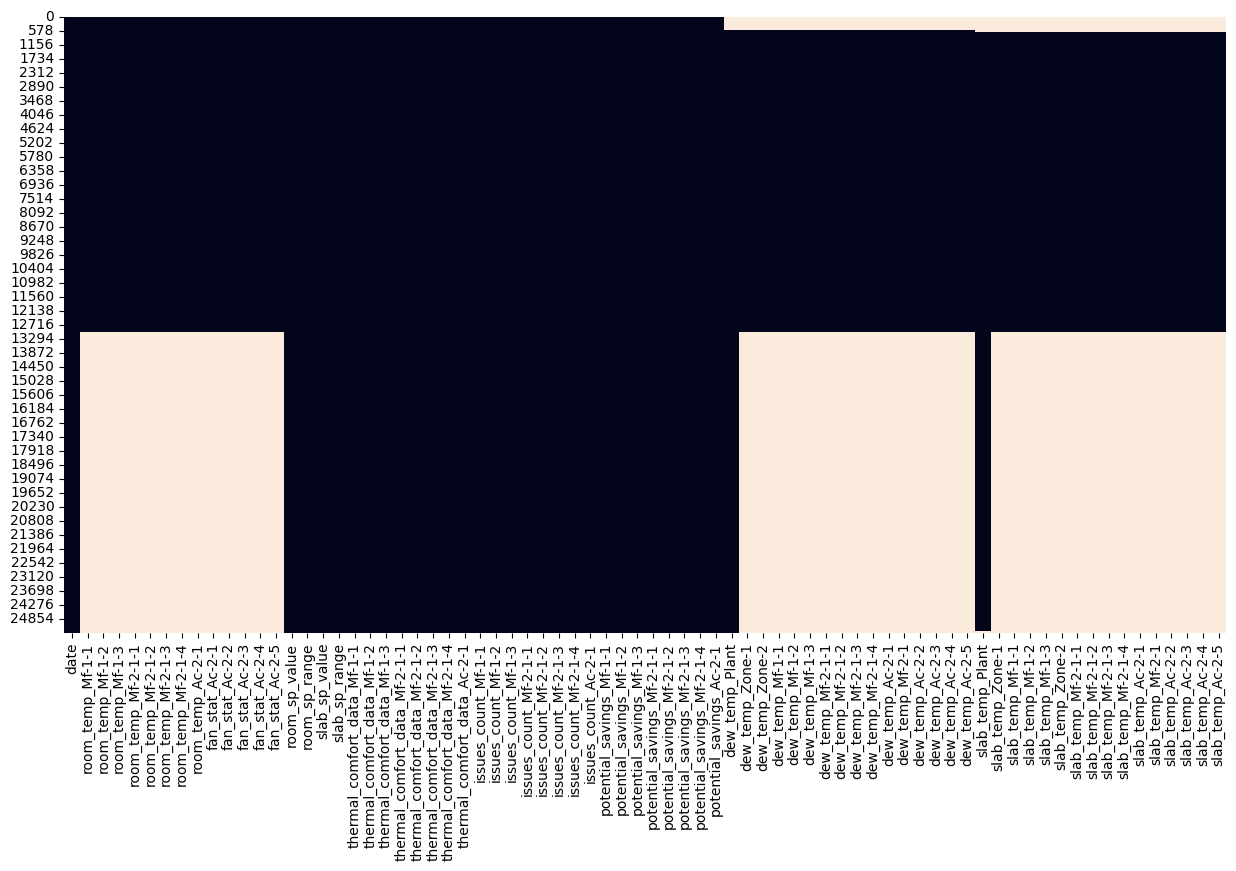

In [49]:
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.heatmap(df_raw.isna(), cbar=False)
plt.show()


In [50]:
df_raw = df_raw.drop(columns=['room_sp_value', 'room_sp_range', 'slab_sp_range', 'slab_sp_value', 'thermal_comfort_data_Mf-1-1', 'thermal_comfort_data_Mf-1-2', 'thermal_comfort_data_Mf-1-3', 'thermal_comfort_data_Mf-2-1-1', 'thermal_comfort_data_Mf-2-1-2', 'thermal_comfort_data_Mf-2-1-3', 'thermal_comfort_data_Mf-2-1-4', 'thermal_comfort_data_Ac-2-1', 'issues_count_Mf-1-1', 'issues_count_Mf-1-2', 'issues_count_Mf-1-3', 'issues_count_Mf-2-1-1', 'issues_count_Mf-2-1-2', 'issues_count_Mf-2-1-3', 'issues_count_Mf-2-1-4', 'issues_count_Ac-2-1', 'potential_savings_Mf-1-1', 'potential_savings_Mf-1-2', 'potential_savings_Mf-1-3', 'potential_savings_Mf-2-1-1', 'potential_savings_Mf-2-1-2', 'potential_savings_Mf-2-1-3', 'potential_savings_Mf-2-1-4', 'potential_savings_Ac-2-1'])

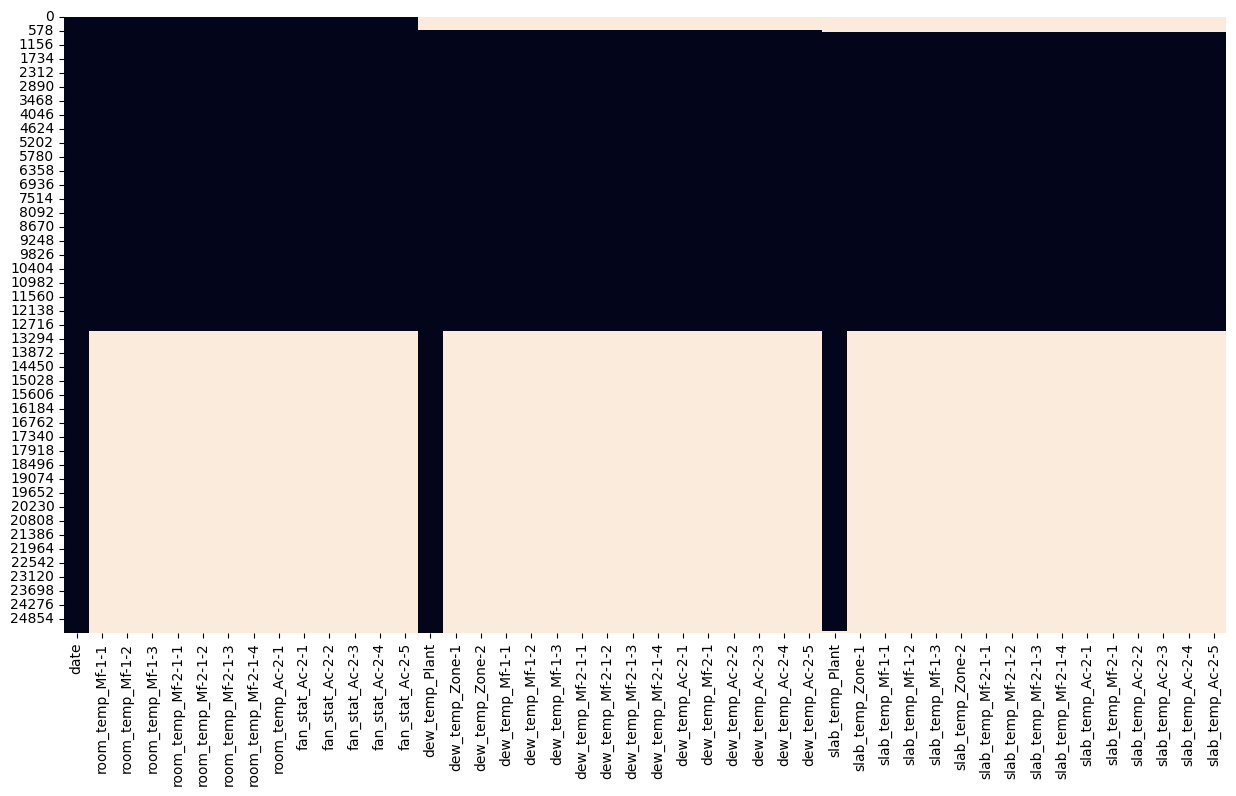

In [51]:
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.heatmap(df_raw.isna(), cbar=False)
plt.show()

In [52]:
import pandas as pd

# Giả sử df là DataFrame của bạn
# 'datetime_column' là tên cột datetime

# Tìm chỉ số của hàng đầu tiên mà tại đó tất cả các cột khác đều null
first_null_index = df_raw.index[df_raw.drop(columns=['date', 'dew_temp_Plant', 'slab_temp_Plant']).isnull().all(axis=1)][0]

# Cắt DataFrame để chỉ giữ lại dữ liệu trước hàng này
df_trimmed = df_raw.loc[:first_null_index-1]

df_trimmed = df_trimmed.fillna(method='ffill').fillna(method='bfill')


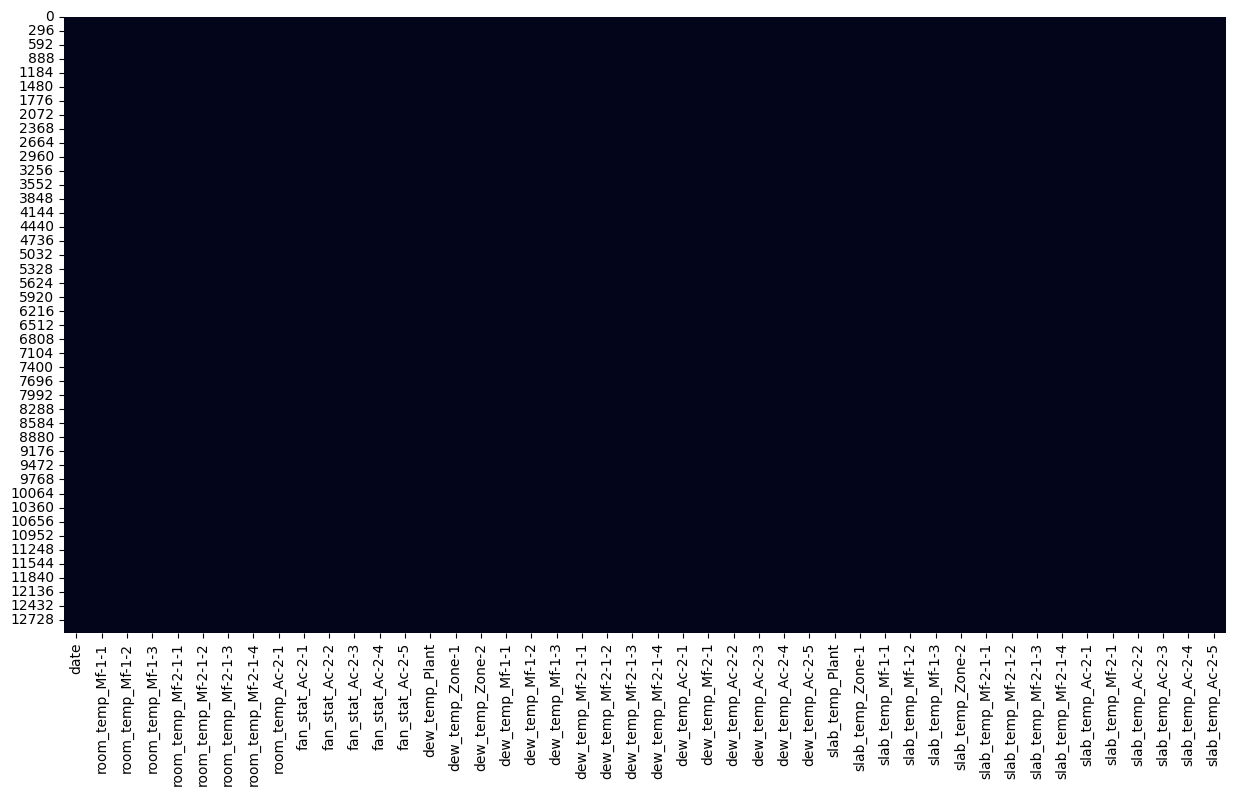

In [53]:
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.heatmap(df_trimmed.isna(), cbar=False)
plt.show()

In [54]:
df_trimmed

,date,room_temp_Mf-1-1,room_temp_Mf-1-2,room_temp_Mf-1-3,room_temp_Mf-2-1-1,room_temp_Mf-2-1-2,room_temp_Mf-2-1-3,room_temp_Mf-2-1-4,room_temp_Ac-2-1,fan_stat_Ac-2-1,...,slab_temp_Mf-2-1-1,slab_temp_Mf-2-1-2,slab_temp_Mf-2-1-3,slab_temp_Mf-2-1-4,slab_temp_Ac-2-1,slab_temp_Mf-2-1,slab_temp_Ac-2-2,slab_temp_Ac-2-3,slab_temp_Ac-2-4,slab_temp_Ac-2-5
0,2023-03-27 21:34:59,19.4,19.8,20.1,20.9,21.3,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
1,2023-03-27 21:43:07,19.4,19.7,20.0,20.9,21.4,20.6,19.5,19.9,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
2,2023-03-27 21:49:07,19.4,19.7,20.0,20.9,21.4,20.6,19.4,19.9,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
3,2023-03-27 22:09:07,19.3,19.7,20.0,20.8,21.3,20.6,19.4,19.9,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
4,2023-03-27 22:29:07,19.3,19.7,20.0,20.8,21.3,20.5,19.3,19.8,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12993,2023-12-07 08:39:08,20.4,20.4,21.0,22.3,22.3,21.4,20.9,21.2,0.0,...,19.7,19.7,19.7,19.7,19.7,19.7,19.7,19.7,19.7,19.7
12994,2023-12-07 08:59:13,20.4,20.5,21.0,22.6,22.4,21.4,20.9,21.2,0.0,...,19.7,19.7,19.7,19.7,19.7,19.7,19.7,19.7,19.7,19.7
12995,2023-12-07 09:19:08,20.4,20.5,21.0,22.8,22.6,21.5,20.9,21.3,0.0,...,19.7,19.7,19.7,19.7,19.7,19.7,19.7,19.7,19.7,19.7
12996,2023-12-07 09:39:10,20.5,20.6,21.0,22.9,22.7,21.5,21.0,21.4,0.0,...,19.6,19.6,19.6,19.6,19.6,19.6,19.6,19.6,19.6,19.6


### Proprocess dataframe

`tsai` provides some sklearn-style transforms that can be used to build a preprocessing pipeline. In this case we'll use the following transforms:

* TSShrinkDataFrame: to save some memory and set the right dtypes.
* TSDropDuplicates: to ensure there are no duplicate timestamps.
* TSAddMissingTimestamps: to fill any missing timestamps.
* TSFillMissing: to fill any missing data (forward fill, then 0).

All these transforms can be applied to the entire dataset. In other words, they are not dependent on the training set. Other transforms will be applied later, when the training split is available.

You can read about all available transforms in the [docs](https://timeseriesai.github.io/tsai/data.preprocessing.html#sklearn-api-transforms).

In [55]:
datetime_col = "date"
freq = '10T' # Thay đổi freq để phù hợp với dữ liệu theo giờ
columns = df_trimmed.columns[1:] # Điều chỉnh nếu cần
method = 'ffill' # Phương thức điền dữ liệu bị thiếu
value = 0 # Giá trị sử dụng khi không có giá trị trước đó

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # add missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ],
    verbose=True)

mkdir('data', exist_ok=True, parents=True)
save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df_trimmed)

df

data directory already exists.
Pipeline saved as data/preproc_pipe.pkl
Initial memory usage: 4.56 MB   
Final memory usage  : 2.33 MB    (-48.9%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.1s


,date,room_temp_Mf-1-1,room_temp_Mf-1-2,room_temp_Mf-1-3,room_temp_Mf-2-1-1,room_temp_Mf-2-1-2,room_temp_Mf-2-1-3,room_temp_Mf-2-1-4,room_temp_Ac-2-1,fan_stat_Ac-2-1,...,slab_temp_Mf-2-1-1,slab_temp_Mf-2-1-2,slab_temp_Mf-2-1-3,slab_temp_Mf-2-1-4,slab_temp_Ac-2-1,slab_temp_Mf-2-1,slab_temp_Ac-2-2,slab_temp_Ac-2-3,slab_temp_Ac-2-4,slab_temp_Ac-2-5
0,2023-03-27 21:34:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
1,2023-03-27 21:44:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
2,2023-03-27 21:54:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
3,2023-03-27 22:04:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
4,2023-03-27 22:14:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36646,2023-12-07 09:14:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
36647,2023-12-07 09:24:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
36648,2023-12-07 09:34:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
36649,2023-12-07 09:44:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0


### Define splits

So we have transformed a multivariate time series with 966 time steps and 7 features (excluding the datetime) into:

* 803 input samples, with 7 features and 104 historical time steps
* 803 input samples, with 7 features and 60 future time steps.

In [56]:
# prompt: show df data

df.tail()


,date,room_temp_Mf-1-1,room_temp_Mf-1-2,room_temp_Mf-1-3,room_temp_Mf-2-1-1,room_temp_Mf-2-1-2,room_temp_Mf-2-1-3,room_temp_Mf-2-1-4,room_temp_Ac-2-1,fan_stat_Ac-2-1,...,slab_temp_Mf-2-1-1,slab_temp_Mf-2-1-2,slab_temp_Mf-2-1-3,slab_temp_Mf-2-1-4,slab_temp_Ac-2-1,slab_temp_Mf-2-1,slab_temp_Ac-2-2,slab_temp_Ac-2-3,slab_temp_Ac-2-4,slab_temp_Ac-2-5
36646,2023-12-07 09:14:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
36647,2023-12-07 09:24:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
36648,2023-12-07 09:34:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
36649,2023-12-07 09:44:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
36650,2023-12-07 09:54:59,19.4,19.799999,20.1,20.9,21.299999,20.6,19.5,20.0,0.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0


It's very easy to create time forecasting splits in `tsai`. You can use as function called `get_forecasting_splits`:

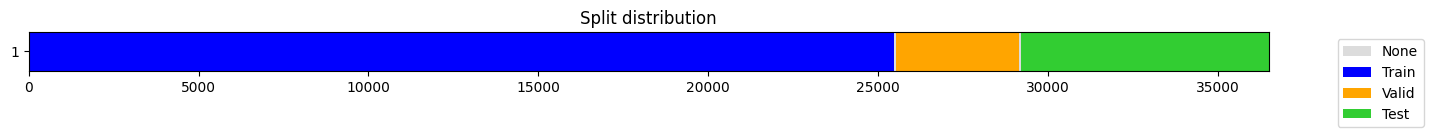

In [57]:
fcst_history = 104 # steps in the past
fcst_horizon = 60  # steps in the future
total_fcst_size = fcst_history + fcst_horizon

# Số lượng mẫu dự báo tối đa có thể có
max_possible_samples = 5473 - total_fcst_size + 1

valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

# Kiểm tra xem valid_size và test_size có phải là tỷ lệ phần trăm không
if isinstance(valid_size, float) and isinstance(test_size, float):
    if valid_size + test_size > 1.0:
        raise ValueError("The sum of valid_size and test_size should not exceed 1.0")

# Kiểm tra xem tổng số mẫu dành cho validation và test có vượt quá max_possible_samples không
if isinstance(valid_size, int) and isinstance(test_size, int):
    if valid_size + test_size > max_possible_samples:
        raise ValueError("The total number of samples for validation and test sets exceeds the maximum possible samples")

splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)


However, in this example, we are going to apply the same splits they used in the original paper. You can use `get_forecasting splits` to use them.

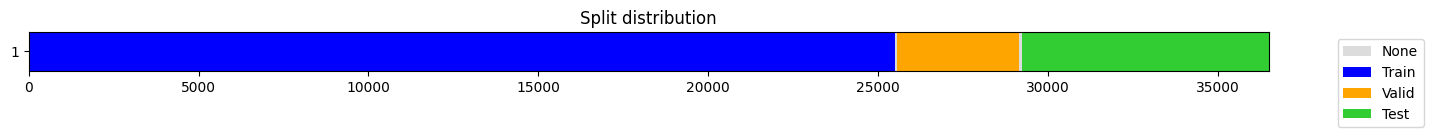

((#25492) [0,1,2,3,4,5,6,7,8,9...],
 (#3607) [25551,25552,25553,25554,25555,25556,25557,25558,25559,25560...],
 (#7271) [29217,29218,29219,29220,29221,29222,29223,29224,29225,29226...])

In [58]:
splits = get_long_term_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, dsid=dsid)
splits

### Scale dataframe

Now that we have defined the splits for this particular experiment, we'll scale the data:

In [59]:
columns = df.columns[1:]
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ],
    verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

data directory already exists.
Pipeline saved as data/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.1s


,date,room_temp_Mf-1-1,room_temp_Mf-1-2,room_temp_Mf-1-3,room_temp_Mf-2-1-1,room_temp_Mf-2-1-2,room_temp_Mf-2-1-3,room_temp_Mf-2-1-4,room_temp_Ac-2-1,fan_stat_Ac-2-1,...,slab_temp_Mf-2-1-1,slab_temp_Mf-2-1-2,slab_temp_Mf-2-1-3,slab_temp_Mf-2-1-4,slab_temp_Ac-2-1,slab_temp_Mf-2-1,slab_temp_Ac-2-2,slab_temp_Ac-2-3,slab_temp_Ac-2-4,slab_temp_Ac-2-5
0,2023-03-27 21:34:59,1.907349,0.0,-1.907349,1.907349,0.0,-1.907349,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-03-27 21:44:59,1.907349,0.0,-1.907349,1.907349,0.0,-1.907349,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-03-27 21:54:59,1.907349,0.0,-1.907349,1.907349,0.0,-1.907349,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-03-27 22:04:59,1.907349,0.0,-1.907349,1.907349,0.0,-1.907349,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-03-27 22:14:59,1.907349,0.0,-1.907349,1.907349,0.0,-1.907349,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36646,2023-12-07 09:14:59,1.907349,0.0,-1.907349,1.907349,0.0,-1.907349,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36647,2023-12-07 09:24:59,1.907349,0.0,-1.907349,1.907349,0.0,-1.907349,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36648,2023-12-07 09:34:59,1.907349,0.0,-1.907349,1.907349,0.0,-1.907349,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36649,2023-12-07 09:44:59,1.907349,0.0,-1.907349,1.907349,0.0,-1.907349,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Apply a sliding window

We'll approach the time series forecasting task as a supervised learning problem. Remember that `tsai` requires that both inputs and outputs have the following shape:

![text.png](attachment:text.png)

To get those inputs and outputs we're going to use a function called `prepare_forecasting_data` that applies a sliding window along the dataframe:

![sliding_window.png](attachment:sliding_window.png)

To use `prepare_forecasting_data` we need to define some settings:

In [60]:
x_vars = df.columns[1:]
y_vars = df.columns[1:]

In [61]:
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((36488, 45, 104), (36488, 45, 60))

# Prepare the forecaster 🏋️‍♂️

Now we'll instantiate the forecaster. In `tsai` there's a class called TSForecaster. We are going to use the same settings they used in the paper.

You can find ILI specific settings here: https://github.com/yuqinie98/PatchTST/blob/main/PatchTST_supervised/scripts/PatchTST/illness.sh

and default model settings here: https://github.com/yuqinie98/PatchTST/blob/main/PatchTST_supervised/run_longExp.py

In [62]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=24,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

In [63]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

☢️ This is **not good practice**, but all papers using these long-term forecasting datasets have published there data using drop_last=True in the validtion set. You should never use it in your practice. But if you want to try and replicate the results from the paper, you may want to uncomment the following line and set `learn.dls.valid.drop_last=True`.

In [64]:
# learn.dls.valid.drop_last = True

In [65]:
learn.summary()

not enough values to plot a chart


PatchTST (Input shape: 16 x 45 x 104)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 45 x 60        
RevIN                                     90         True      
____________________________________________________________________________
                     16 x 45 x 106       
ReplicationPad1d                                               
____________________________________________________________________________
                     16 x 24 x 42        
Unfold                                                         
____________________________________________________________________________
                     16 x 45 x 42 x 16   
Linear                                    400        True      
Dropout                                                        
Linear                                    272        True      
Linear                                    272        True      
Linear                                    272      

As you can see this is a very small model, with only 57k parameters!

# Train model 🏃🏿‍♂️

In this case we'll use the same number of epochs and learning rate they used in the paper.

⚠️ Whenever you need to look for a good learning rate to train a model you can use:
```python
lr_max = learn.lr_find().valley
```

epoch,train_loss,valid_loss,mse,mae,time
0,0.000000,0.000000,0.000000,0.000001,00:45
1,0.000000,0.000000,0.000000,0.000001,00:38
2,0.000000,0.000000,0.000000,0.000001,00:37
3,0.000000,0.000000,0.000000,0.000001,00:37
4,0.000000,0.000000,0.000000,0.000001,00:37
5,0.000000,0.000000,0.000000,0.000001,00:38
6,0.000000,0.000000,0.000000,0.000001,00:37
7,0.000000,0.000000,0.000000,0.000001,00:37
8,0.000000,0.000000,0.000000,0.000001,00:37
9,0.000000,0.000000,0.000000,0.000001,00:37


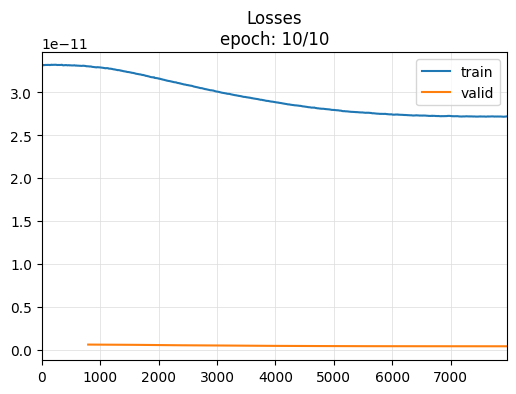

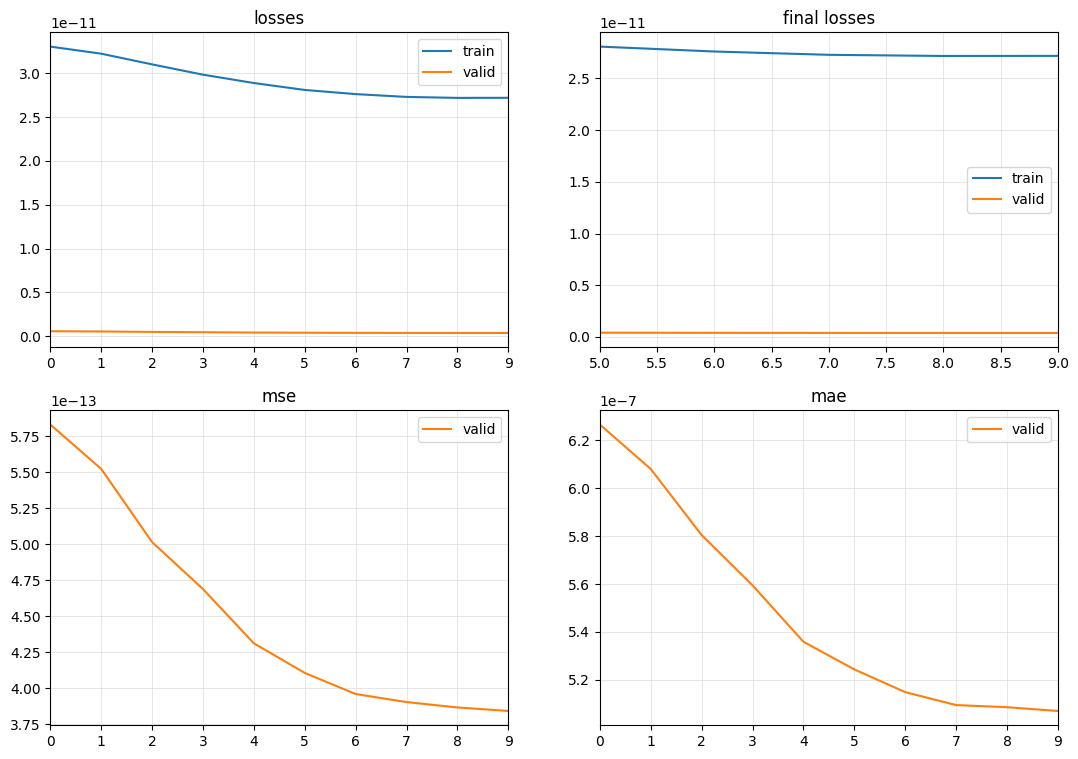

In [66]:
learn = TSForecaster(X, y, splits=splits, batch_size=32, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 10
lr_max = 0.0025
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')

# Evaluate model 🕵️‍♀️

## Valid split

First we are going to check that the valid predictions match the results we got during training. But you can skip this step since it's not required.

In [67]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(X[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df

scaled_preds.shape: (3607, 45, 60)


,mse,mae
valid,0.0,0.0


## Test split

So now we'll use the test split to measure performance (this is the one you that is published in the paper).

⚠️ You may find some differences due to randomness of the process. In addition to that, the authors used a test dataloader that drop the last batch if incomplete, which means that not all samples are used to measure performance. In `tsai` we are using all samples.

In [68]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (7271, 45, 60)


,mse,mae
test,0.0,0.0


### Visualize predictions

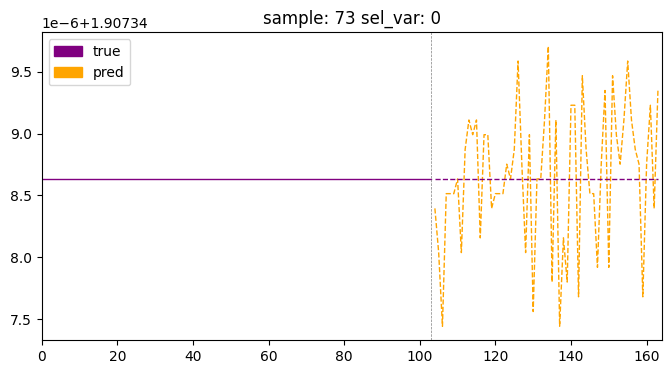

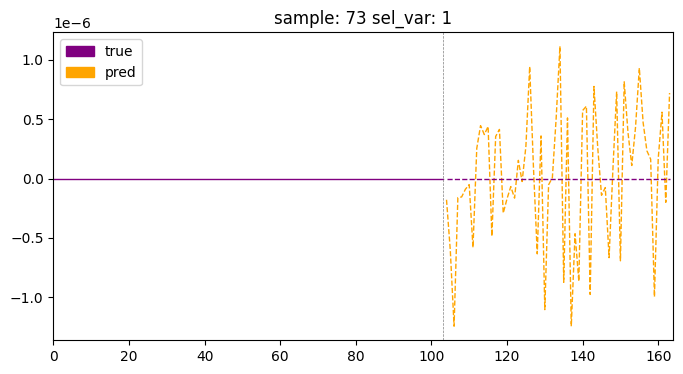

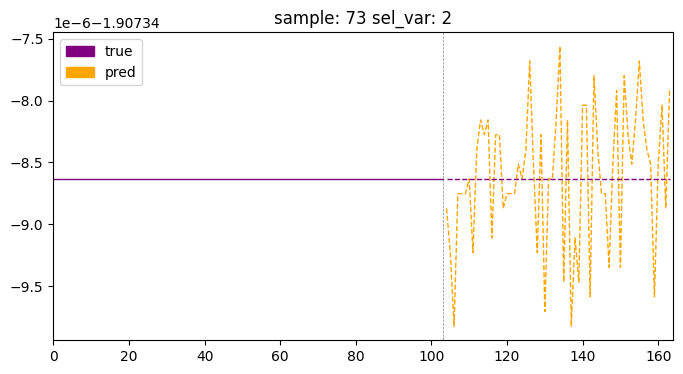

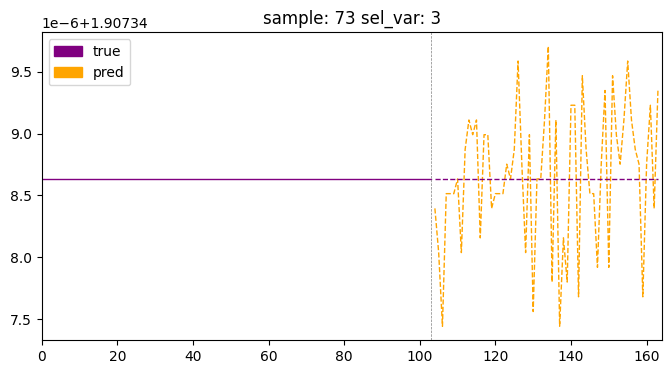

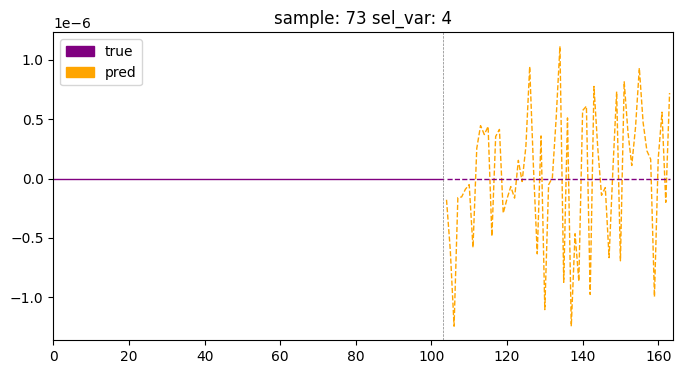

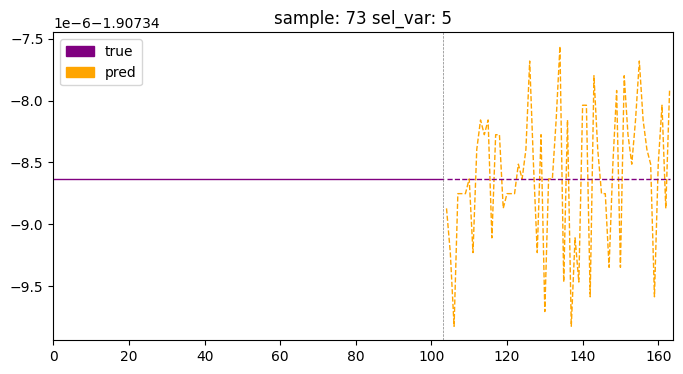

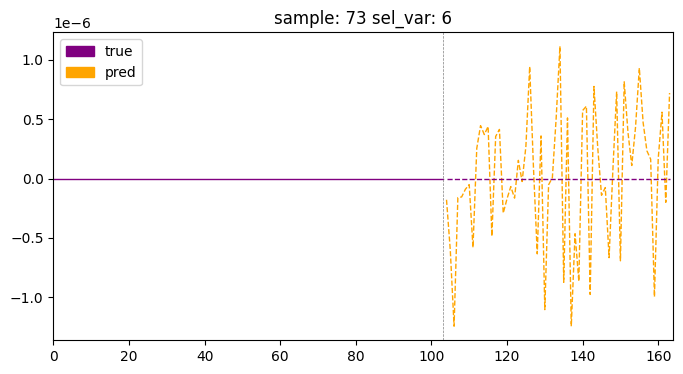

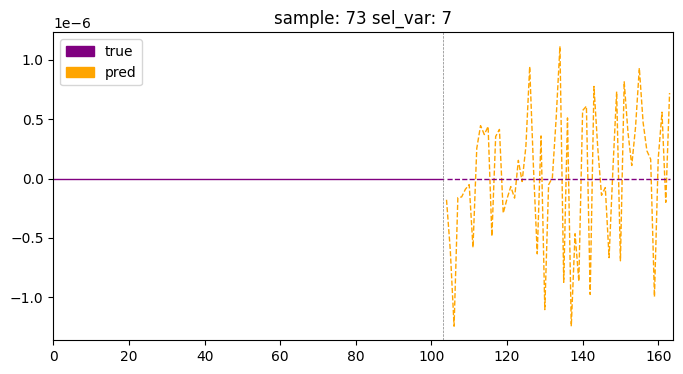

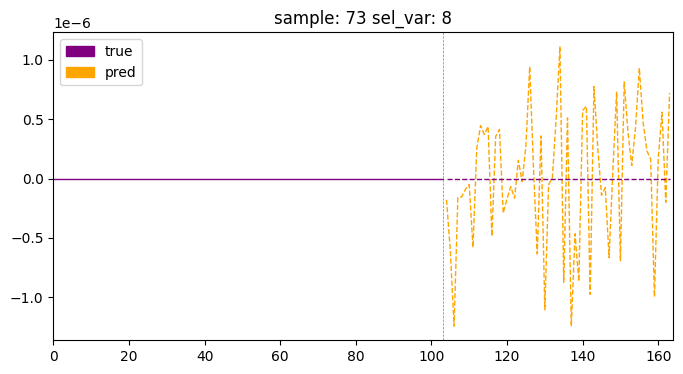

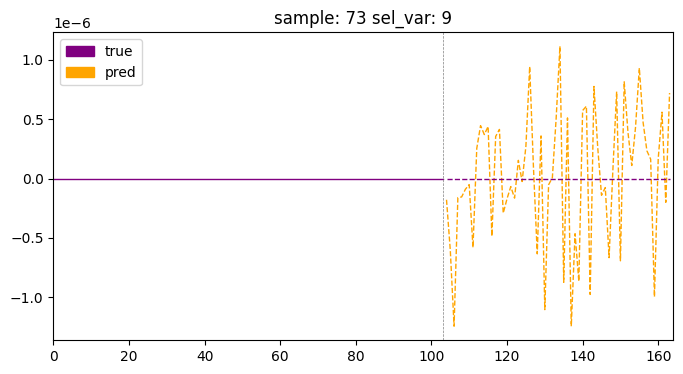

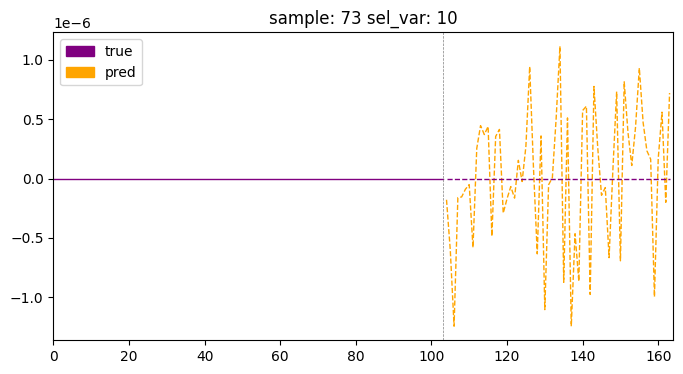

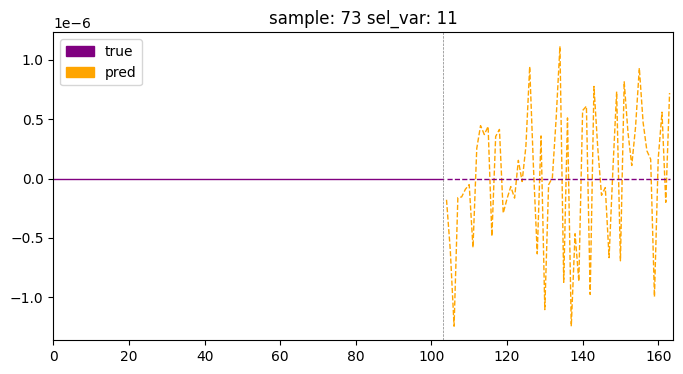

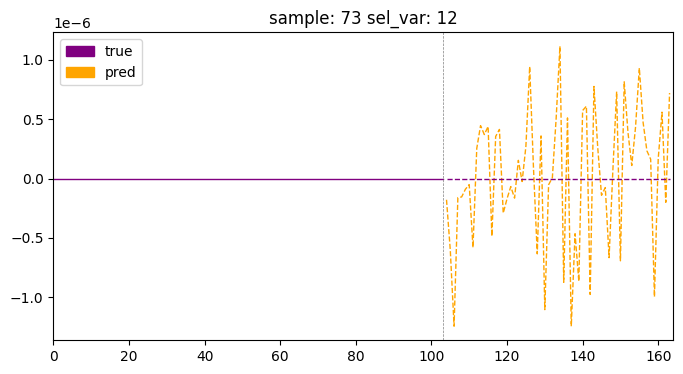

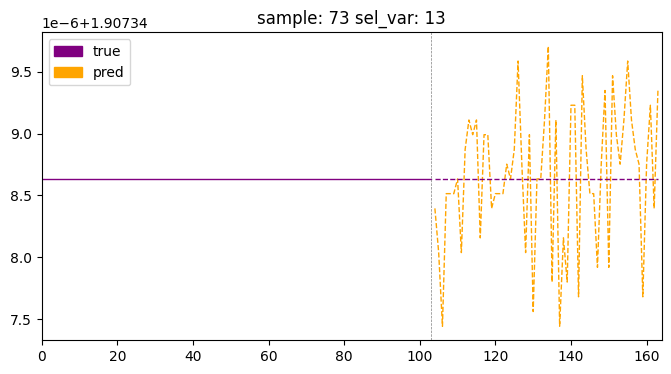

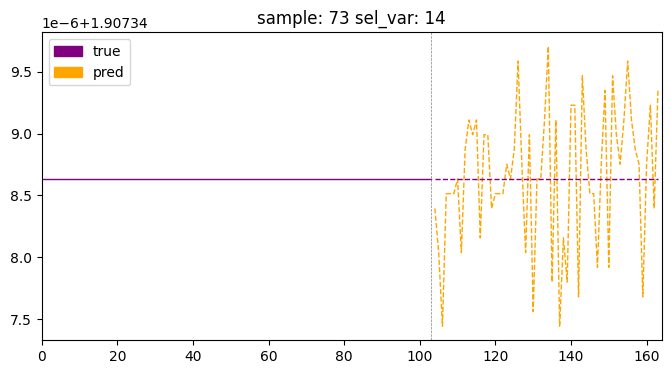

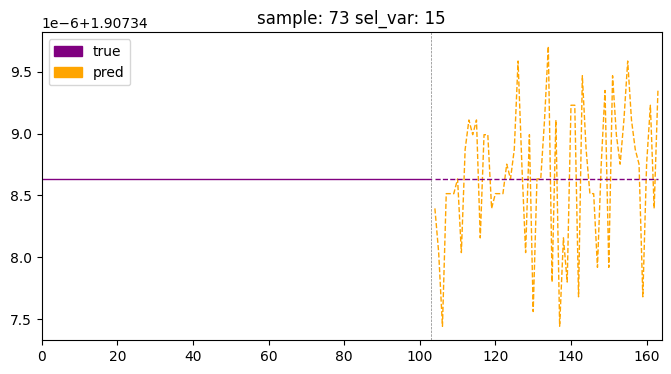

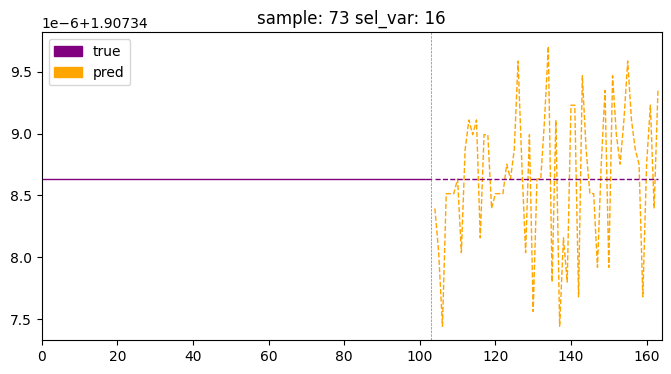

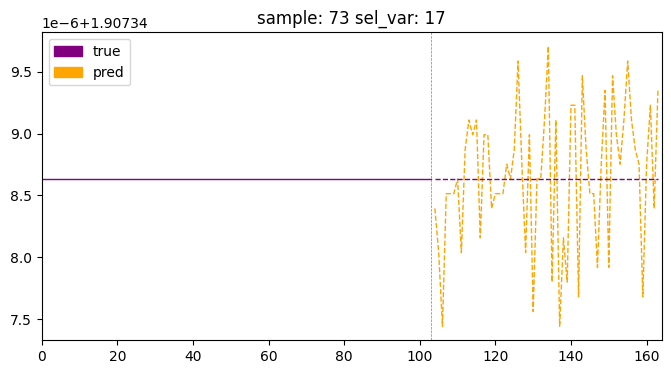

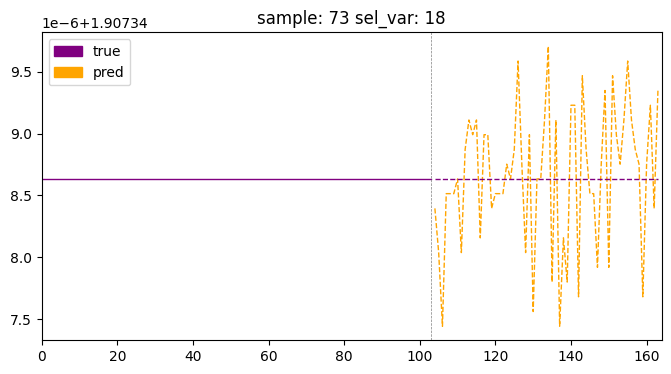

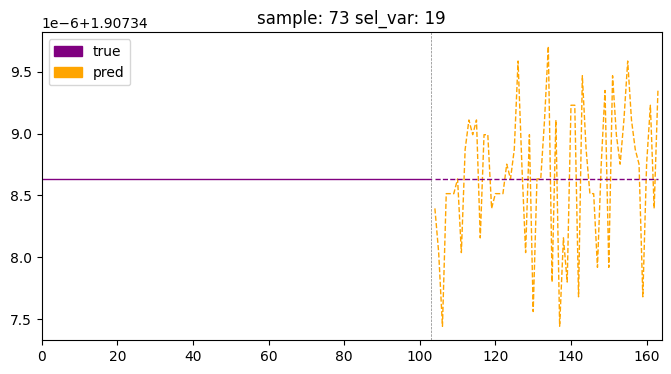

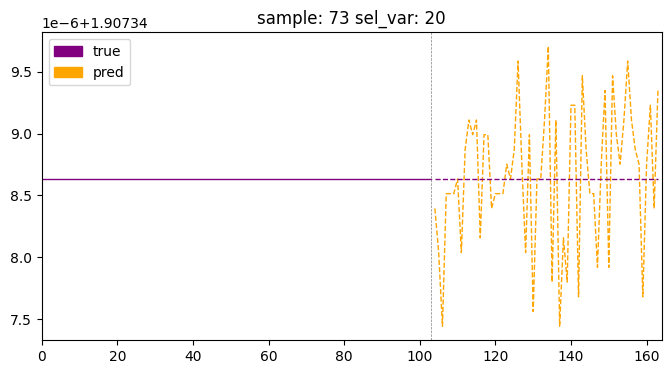

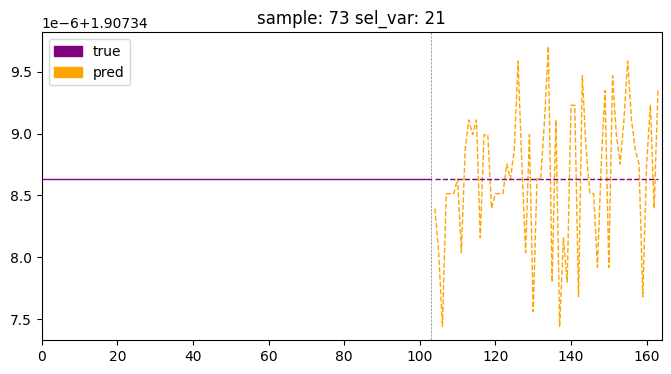

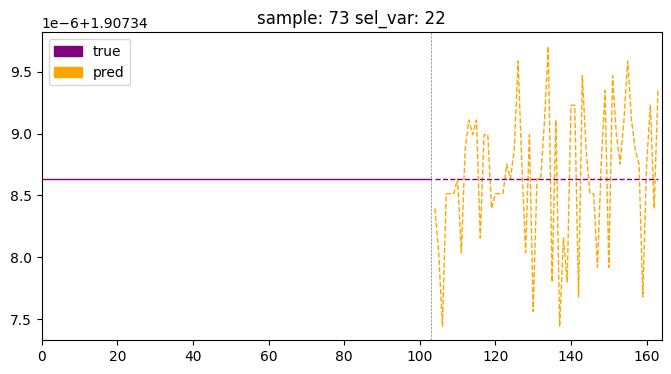

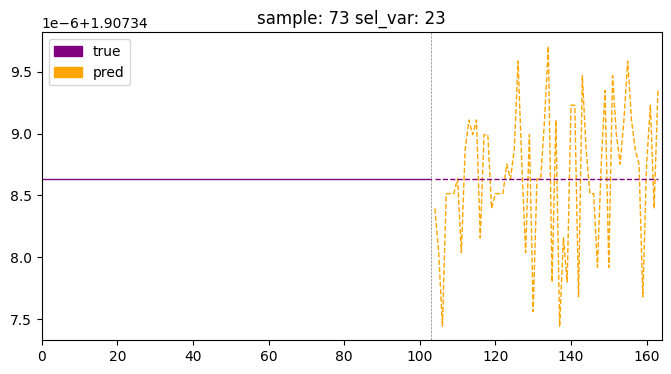

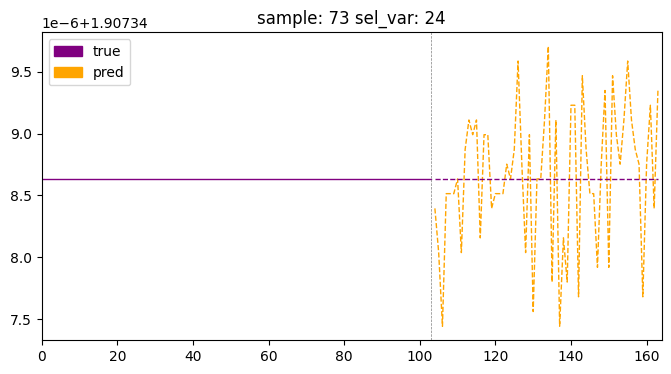

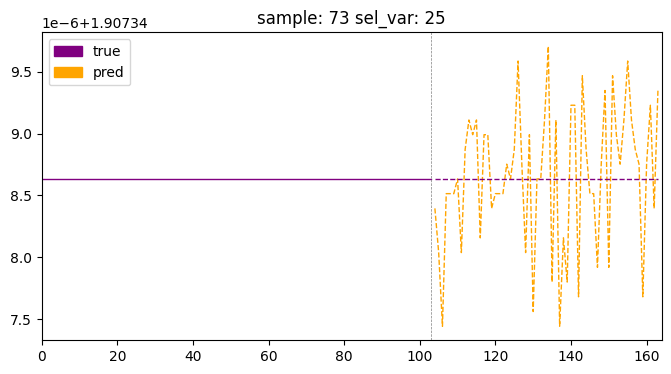

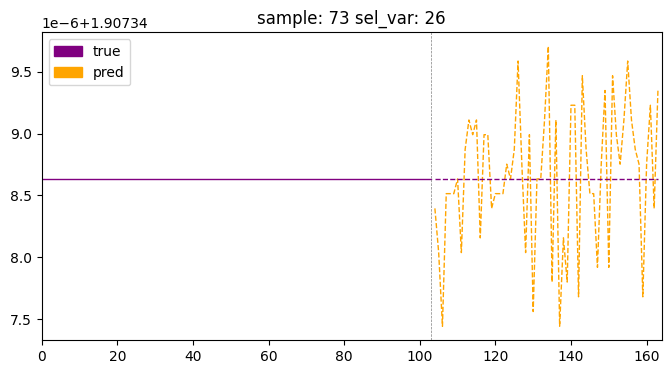

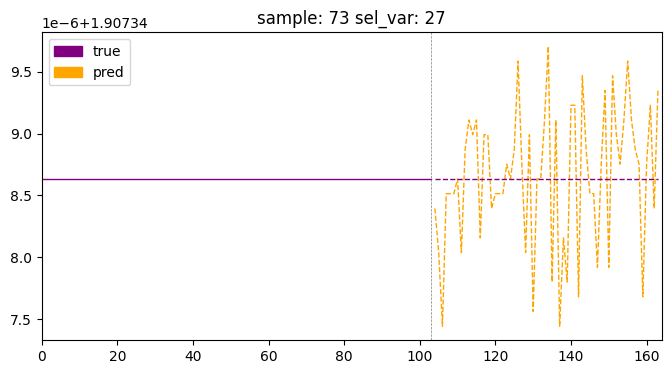

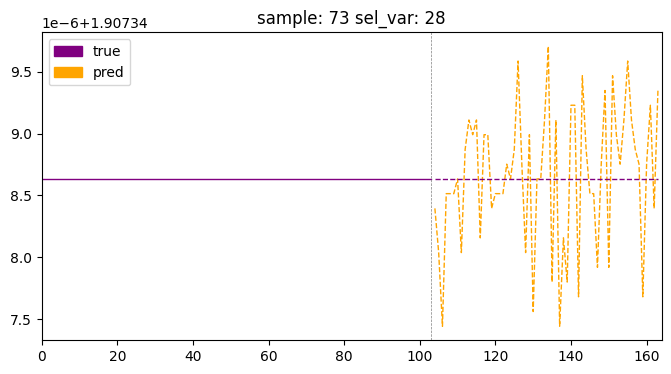

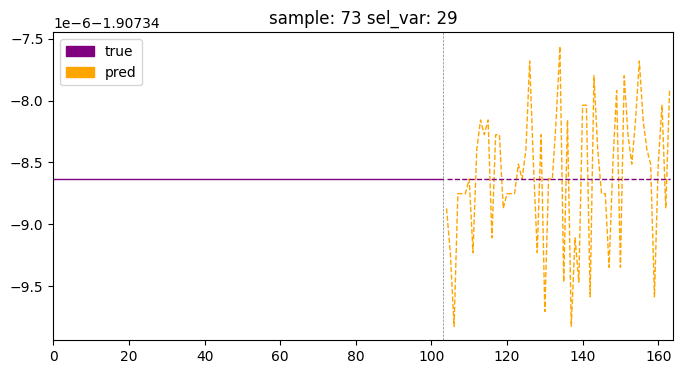

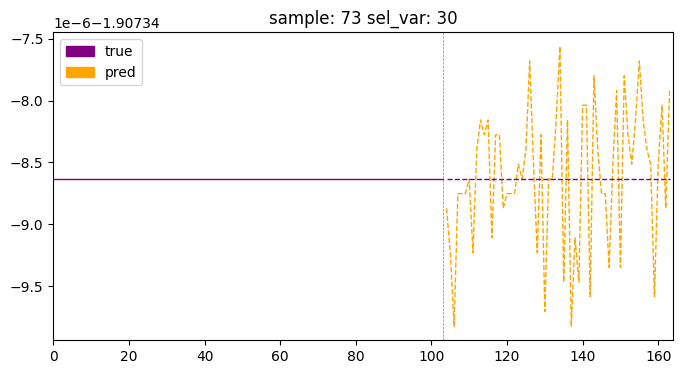

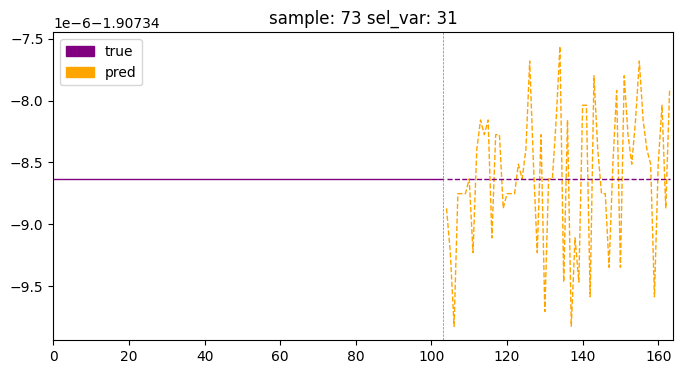

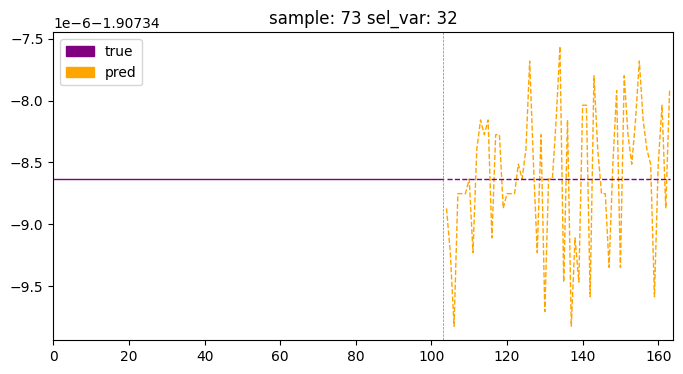

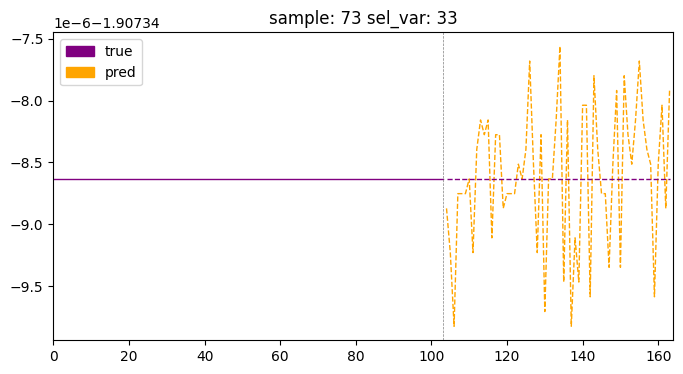

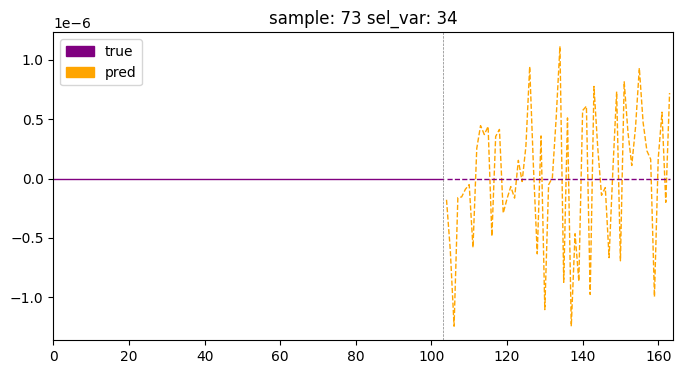

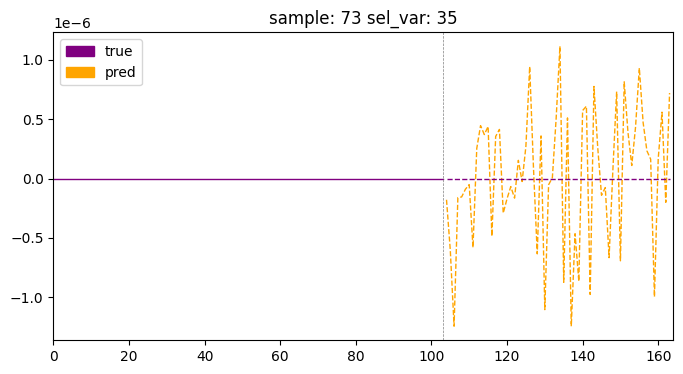

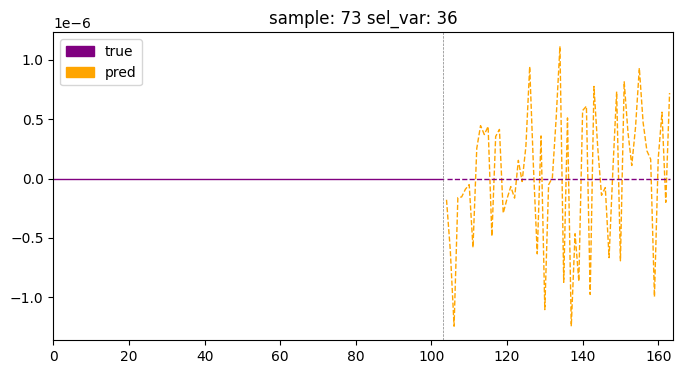

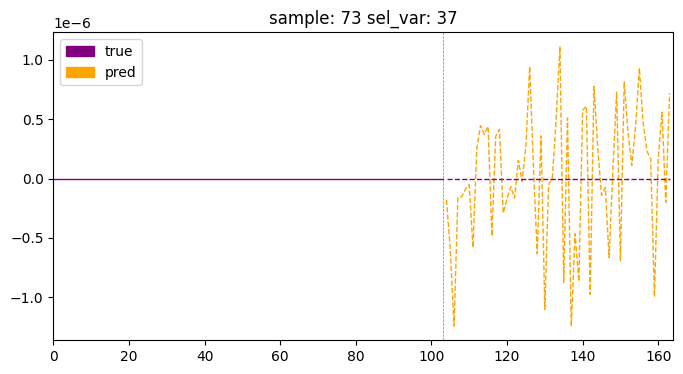

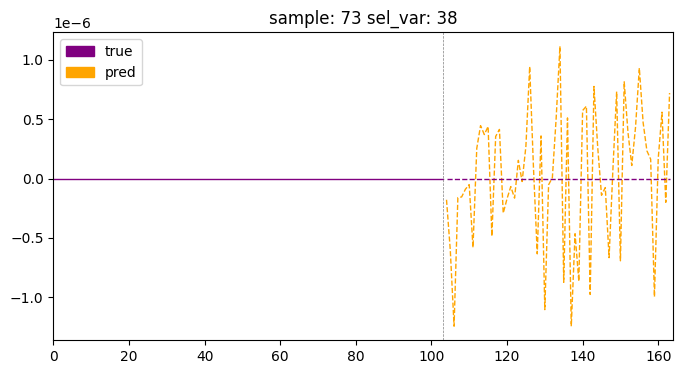

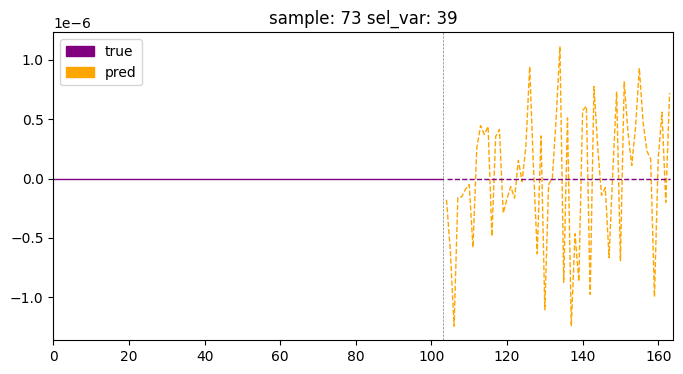

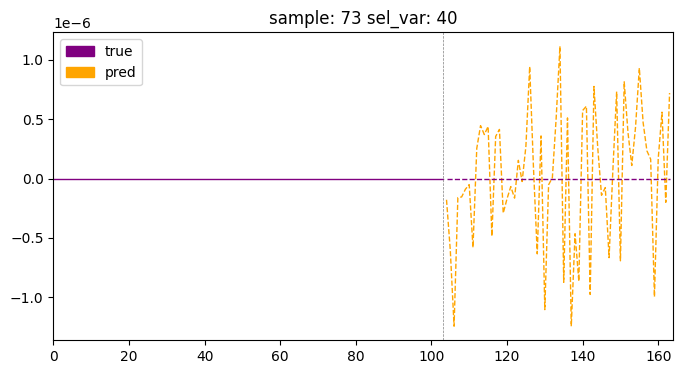

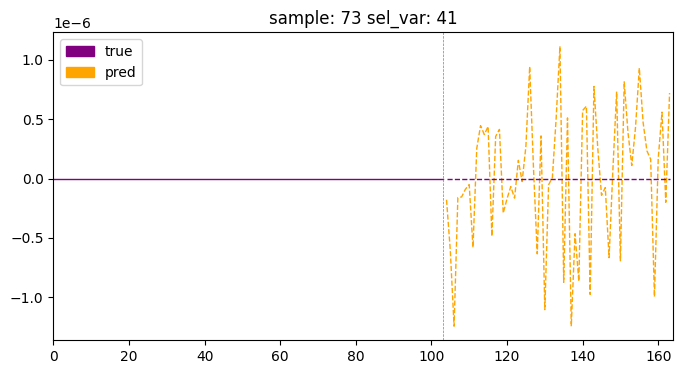

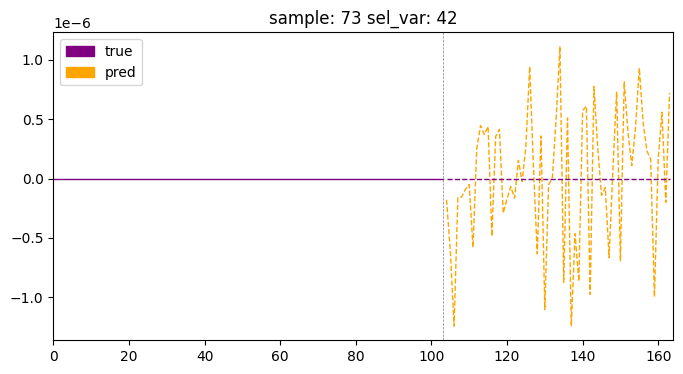

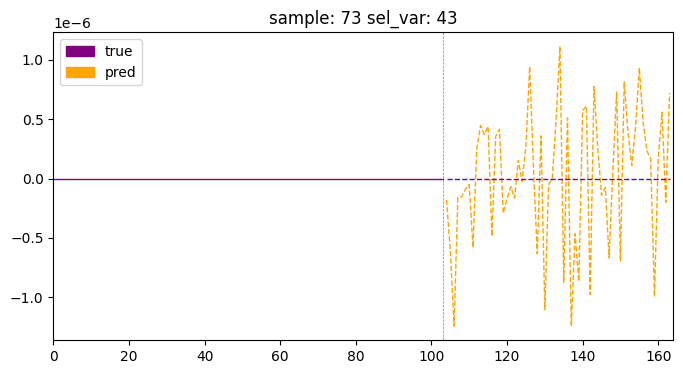

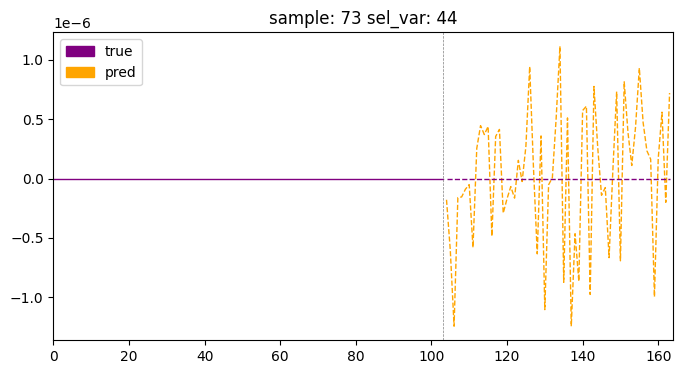

In [69]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)

# Conclusion ✅

In this notebook we have covered the following topics:

* PatchTST: a new state-of-the-art transformer for long-term multivariate time series forecasting.
* how to prepare data for a time series task.
* how to use PatchTST within the tsai framework.
* how to use predict multiple variables and multiple steps into the future.
* how to visualize predictions and compare them to true values.

I hope you've found this helpful. Now it's your opportunity to start creating your own forecasts!